In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
#Set option to see all columns
pd.set_option('display_max_columns', None)


OptionError: No such keys(s): 'display_max_columns'

In [8]:
#Load data
print("Loading data...")
data_path = 'ai_lending_club_loan_data/accepted_2007_to_2018Q4.csv.gz'
df = pd.read_csv(data_path)
print("Data loaded successfully")

Loading data...


/var/folders/n1/bmjsnf2966g83zq6vpf1f_xh0000gn/T/ipykernel_76951/2215923803.py:4: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Data loaded successfully


In [10]:
#Shape of data {rows, columns}
print(f"Dataset shape: {df.shape}")

#look at first few rows
print(df.head())

Dataset shape: (2260701, 151)
         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   
3     14.85       829.90     C        C5  ...                            NaN   
4     22.45       289.91     F        F1  ...                            NaN   

  hardship_las

In [12]:
#Find and see all unique values in 'loan_status' column and how many of each
print(df['loan_status'].value_counts())

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64


In [25]:
#Define what is a "good" or "bad" loan
good_loan_statuses = ["Fully Paid", "Does not meet the credit policy. Status: Fully Paid"]
bad_loan_statuses = ["Charged Off", "Default", "Does not meet credit policy. Status: Charged Off"]


In [26]:
#Filter the df to only include loans with these statuses
df_filtered = df[df['loan_status'].isin(good_loan_statuses + bad_loan_status)].copy()

In [27]:
#create our binary target column: 1 for bad, 0 for good
df_filtered.loc[:, 'is_default'] = df_filtered['loan_status'].apply(lambda x: 1 if x in bad_loan_statuses else 0)

In [29]:
# Verification
print(f"Shape of the  DataFrame before filtering: {df.shape}")
print(f"Shape of the DataFrame after filtering: {df_filtered.shape}")
print("\nNew target variable 'is_default' distribution:")
#Use normalize=True to see percentages
print(df_filtered['is_default'].value_counts(normalize=True))

Shape of the  DataFrame before filtering: (1345350, 151)
Shape of the DataFrame after filtering: (1345350, 152)

New target variable 'is_default' distribution:
is_default
0    0.80035
1    0.19965
Name: proportion, dtype: float64


In [32]:
#Feature Cleaning & Elimination

# Calculate the percentage of missing values for each column in our new dataframe
missing_percentage = df_filtered.isnull().sum() / len(df_filtered) * 100

# Get the columns that have more than 40% missing values
columns_to_drop = missing_percentage[missing_percentage > 40].index

print(f"Found {len(columns_to_drop)} columns with more than 40% missing data.")
print("These columns will be dropped.")
# print(columns_to_drop.tolist())
# Optional: uncomment to see the list of dropped columns

# Drop these columns from our dataframe
df_cleaned = df_filtered.drop(columns=columns_to_drop)

print(f"\nShape of DataFrame before dropping missing columns: {df_filtered.shape}")
print(f"Shape of DataFrame after dropping missing columns: {df_cleaned.shape}")

Found 58 columns with more than 40% missing data.
These columns will be dropped.

Shape of DataFrame before dropping missing columns: (1345350, 152)
Shape of DataFrame after dropping missing columns: (1345350, 94)


In [35]:
# List of columns to manually remove
manual_cols_to_drop = [
    'id', 'member_id', 'url', 'desc', 'title', 'emp_title',
    'zip_code', 'addr_state', # Often too granular or can introduce bias
    'loan_status', # We already have 'is_default'
    # Data leakage columns (info not available at time of application)
    'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
    'out_prncp', 'out_prncp_inv'
]

# Make sure all columns in the list exist in the dataframe before trying to drop
existing_cols_to_drop = [col for col in manual_cols_to_drop if col in df_cleaned.columns]

df_model_ready = df_cleaned.drop(columns=existing_cols_to_drop)

print(f"\nShape after dropping manual columns: {df_model_ready.shape}")


Shape after dropping manual columns: (1345350, 75)


In [36]:
#Feature engineering and preprocessing

#copy to make sure previous step was saved
df_processed = df_model_ready.copy()

#Step 1 - Correcting data types

#Handle term column - Before: " 36 months" -> After: 36
df_processed['term'] = df_processed['term'].str.extract('(\\d+)').astype(int)

#handle the "emp_length" column. There's also "10+ years" and "<1 year"
df_processed['emp)length'] = df_processed['emp_length'].str.replace(' years', '')
df_processed['emp)length'] = df_processed['emp_length'].str.replace(' year', '')
df_processed['emp)length'] = df_processed['emp_length'].str.replace('+ ', '')
df_processed['emp)length'] = df_processed['emp_length'].str.replace('< 1', '0')

#convert to numeric, filling any remaining missing values with 0 for new employees
df_processed['emp_length'] = pd.to_numeric(df_processed['emp_length'], errors = 'coerce').fillna(0)

#verify results
print("Data types for 'term' and 'emp_length' after conversion:")
print(df_processed[['term', 'emp_length']].dtypes)

Data types for 'term' and 'emp_length' after conversion:
term            int64
emp_length    float64
dtype: object


In [38]:
#Convert date columns to datetime objects
df_processed['issue_d'] = pd.to_datetime(df_processed['issue_d'])
df_processed['earliest_cr_line'] = pd.to_datetime(df_processed['earliest_cr_line'])

#Make a new feature - credit history length in days
df_processed['credit_history_length'] = (df_processed['issue_d'] - df_processed['earliest_cr_line']).dt.days

#drop original date columns
df_processed = df_processed.drop(columns = ['issue_d', 'earliest_cr_line'])

#verify results
print("\nFirst 5 values for our new 'credi_history_length', feature:")
print(df_processed['credit_history_length'].head())


First 5 values for our new 'credi_history_length', feature:
0     4505
1     5844
2     5600
4     6392
5    10288
Name: credit_history_length, dtype: int64


In [39]:
#Handle the categorical features

#find all columns that are still 'object' type
categorical_cols = df_processed.select_dtypes(include = 'object').columns

print(f"\nFound {len(categorical_cols)} categorical columns to encode.")

#one-hot encoding
df_processed = pd.get_dummies(df_processed, columns = categorical_cols, drop_first = True)

print(f"\nShape of DF after one-hot encoding: {df_processed.shape}")
print("The number of columns increased as expected.")


Found 12 categorical columns to encode.

Shape of DF after one-hot encoding: (1345350, 137)
The number of columns increased as expected.


In [41]:
#Final data prep

#impute remaining missing values with the median
print(f"Number of missing values before imputation: {df_processed.isnull().sum().sum()}")
df_final = df_processed.fillna(df_processed.median())
print(f"Number of missing values after imputation: {df_final.isnull().sum().sum()}")

Number of missing values before imputation: 2363023
Number of missing values after imputation: 0


In [43]:
#Separates features and targets
x = df_final.drop('is_default', axis = 1)
y = df_final['is_default']

print("\nShape of features (x):", x.shape)
print("Shape of target (y):", y.shape)


Shape of features (x): (1345350, 136)
Shape of target (y): (1345350,)


In [44]:
from sklearn.model_selection import train_test_split

In [47]:
#split the data: 80% for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)
#stratify = y ensures that 20% default rate is preserved in both training and testing sets, so the split representative is of the whole dataset

print("\nShape of training features:", x_train.shape)
print("Shape of testing features:", x_test.shape)


Shape of training features: (1076280, 136)
Shape of testing features: (269070, 136)


In [48]:
#SMOTE - Synthetic Minority Over-sampling Technique (only applies to training data)
from imblearn.over_sampling import SMOTE


In [49]:
print("\nDistribution of target in original training data:")
print(y_train.value_counts(normalize=True))

#initialize smote
smote = SMOTE(random_state = 42)

#apply SMOTE to training data
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print("\nDistribution of target in resampled training data:")
print(y_train_resampled.value_counts(normalize=True))
print("\nShape of resampled training features:", x_train_resampled.shape)


Distribution of target in original training data:
is_default
0    0.80035
1    0.19965
Name: proportion, dtype: float64

Distribution of target in resampled training data:
is_default
0    0.5
1    0.5
Name: proportion, dtype: float64

Shape of resampled training features: (1722802, 136)


In [51]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

#train and evaluate the XGBoost model
print("Training the XGBoost model... this may take a few minutes.")

#initialize and train the xgboost classifier
#use common starting parameters. 'eval_metric' helps the model improve
model = xgb.XGBClassifier(objective = 'binary:logistic',
                          eval_metric = 'logloss',
                          use_label_encoder = False,
                          random_state = 42)
model.fit(x_train_resampled, y_train_resampled)

print("Model training complete")

#make predictions on the unseen test data
print("\nMaking predictions on the test set...")
y_pred = model.predict(x_test)

#Evaluate model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names =  ['Good Loan (0)', 'Default (1)']))

Training the XGBoost model... this may take a few minutes.


/Users/aidenkim/Documents/Projects/CreditRiskModel/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:50:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete

Making predictions on the test set...

Model accuracy: 0.9181

Classification Report:
               precision    recall  f1-score   support

Good Loan (0)       0.95      0.95      0.95    215350
  Default (1)       0.80      0.79      0.79     53720

     accuracy                           0.92    269070
    macro avg       0.87      0.87      0.87    269070
 weighted avg       0.92      0.92      0.92    269070




Calculating SHAP values... this can take a moment


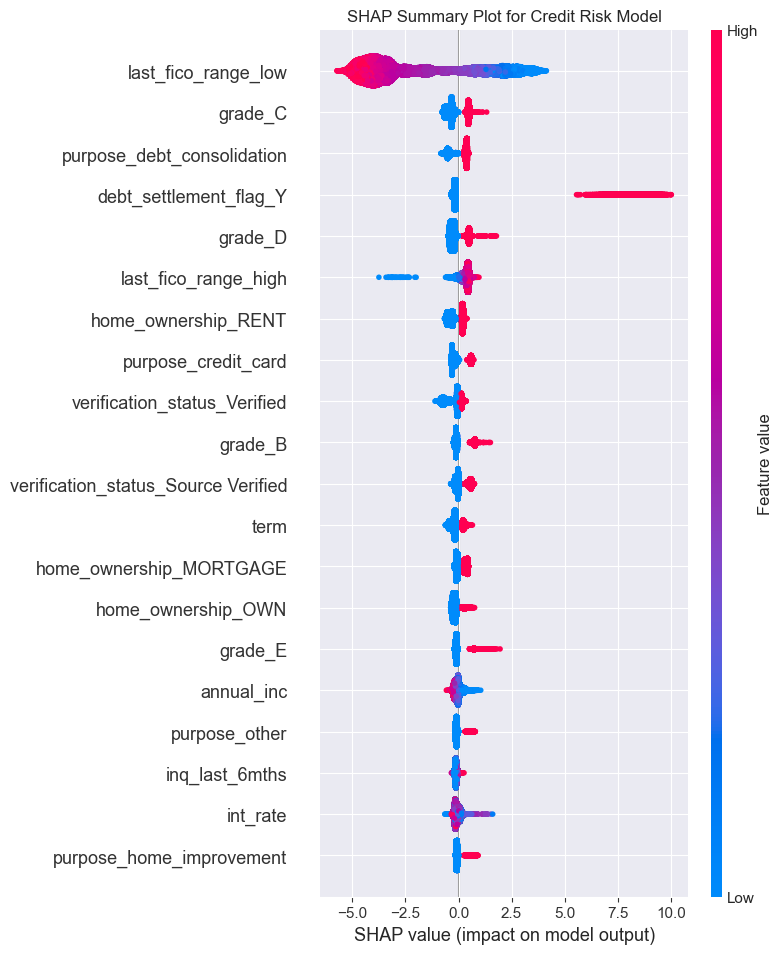

In [53]:
import shap

#shap can explain the model predictions

print("\nCalculating SHAP values... this can take a moment")

#create shap explainer object
explainer = shap.TreeExplainer(model)

#calculate SHAP values for test set
shap_values = explainer.shap_values(x_test)

#create the summary plot
shap.summary_plot(shap_values, x_test, show=False)
plt.title("SHAP Summary Plot for Credit Risk Model")
plt.show()
